### TO DO 
* ~Include account attributes in query~   
* ~Append account attributes to final output~  
* ~revisit original query~ 
* ~Add individual name back to node labels~
* ~Generate more summary statistics for output~  
* Add creation of member network work key tables: individual_id | network ; member_nbr | network  
* ~Add summary table: network | total loans | total savings | number of members | central member~
* ~Fix pdf output~  
* Fix regex group error https://stackoverflow.com/questions/39901550/python-userwarning-this-pattern-has-match-groups-to-actually-get-the-groups  
* Add gephx file output

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
#import pyodbc
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
from datetime import datetime

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

conn = sqlite3.connect('demo_data.db')

In [2]:
####################################################################
# NEW QUERY FOR HANDLING DATA IN PYTHON TO CREATE ATTRIBUTE DICTIONARIES
####################################################################

node_individual_query = '''
SELECT individual_id,  
first_name ||' '||last_name||' '||individual_id [label],
first_name ||' '||last_name [name],
open_date,
'individual'[type]
from individual_today

'''

member_individual_query = '''
SELECT *, member_nbr [label],
'membership'[type]
FROM agr_membertotal_today 
'''

edge_query = '''
select member_nbr [source], individual_id [target], participation_type
FROM membershipparticipant_today
'''

In [3]:
##Generate graph using from_pandas_edgelist and attribute dictionaries 

ind = pd.read_sql(node_individual_query, conn)
mem = pd.read_sql(member_individual_query, conn)
edges= pd.read_sql(edge_query, conn)

# make attribute dictionary
mem_dict = mem.set_index('member_nbr')
mem_dict = mem_dict.to_dict('index')
ind_dict = ind.set_index('individual_id')
ind_dict = ind_dict.to_dict('index')

mem_dict.update(ind_dict)

#from pandas edgelist
G = nx.from_pandas_edgelist(edges, edge_attr = True)
nx.set_node_attributes(G, mem_dict)

len(G)

200

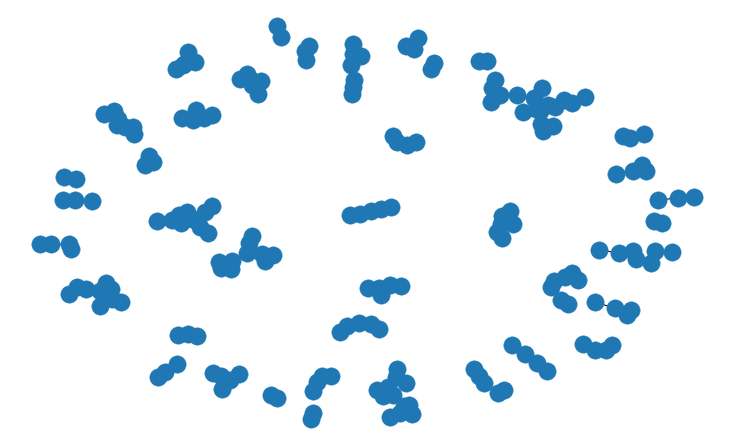

In [4]:
nx.draw(G)

### Graph stats

In [5]:
print(nx.info(G))
print(f'Connected components: {str(nx.number_connected_components(G))}')

Name: 
Type: Graph
Number of nodes: 200
Number of edges: 150
Average degree:   1.5000
Connected components: 50


In [44]:
# Degrees
#degree = nx.degree(G)
#degree

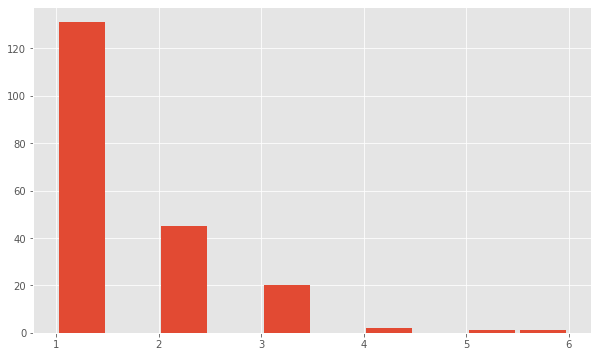

In [45]:
#Degree histogram
plt.rcParams['figure.figsize'] = (10, 6)
degrees = [node[1] for node in degree]
#print (degrees)
plt.hist(degrees, bins=10, rwidth=0.9)
plt.show()

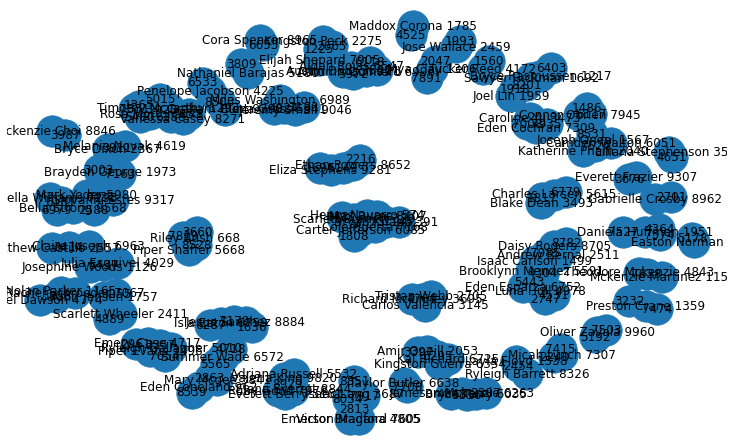

In [8]:
# Show all participants
pos = nx.spring_layout(G)
node_labels = nx.get_node_attributes(G,'label')
nx.draw(G, pos=pos,   node_size=1000)
nx.draw_networkx_labels(G, pos=pos, labels=node_labels )
plt.show()

### Data prep and examining subgraphs

In [9]:
def generate_color_map(graph_object, individual_df):
    ''' Generates a color map corresponding with whether a node represents an individual or membership
    :param graph_object: NetworkX graph object
    :param individual_df: DataFrame of the individual table query
    :return colors: A list of colors to be passed to the networkx.draw() function
    '''
    individual_nodes = list(individual_df['individual_id'])

    for n in graph_object.nodes:
        graph_object.nodes[n]['color'] = 'c' if n in individual_nodes else 'm'
    
    colors = [node[1]['color'] for node in graph_object.nodes(data = True)]
    return(colors)

In [10]:
def separate_members_individuals(graph_object):
    '''separates member nodes from individual nodes
    :param graph_object: The NetworkX graph object
    :return subgraph_individuals: A dictionary of individual nodes and their attributes
    :return subgraph_members: A dictionary of member nodes and their attributes
    '''
    
    subgraph_individuals = {}
    subgraph_members = {}

    for node in graph.nodes.data():
        dic = {node[0]:node[1]}

        if node[1]['type']== 'individual':
            subgraph_individuals.update(dic)

        if node[1]['type']=='membership':
            subgraph_members.update(dic)
            
    return(subgraph_individuals, subgraph_members)

In [42]:
def get_subgraphs(graph_object, min_nodes_in_subgraph):
    '''Finds subgraphs and filters them for minimum number of desired nodes
    :param graph_object: The original big grah
    :param min_nodes_in_subgraph: The minimum number of nodes a subgraph should have
    :return multi: A list of the subgraphs
    '''
    S = [graph_object.subgraph(c).copy() for c in nx.connected_components(graph_object)]
    n = min_nodes_in_subgraph 
    multi=[]
    
    for sub in S:
        if len(nx.nodes(sub))>=n:
            multi.append(sub)
            
    print(f'{len(multi)} networks with at least {n} nodes')
    return(multi)

In [30]:
def get_subgraph_attributes(graph_object):
    '''Returns some attribtues about the subgraphs in a network'''
    
    node_counts = []
    S = [graph_object.subgraph(c).copy() for c in nx.connected_components(graph_object)]
    for sub in S:
        node_count = len(nx.nodes(sub))
        node_counts.append(node_count)
        
    attributes = {'Total Subgraphs':len(S),
                  'Min Nodes':min(node_counts),
                  'Max Nodes':max(node_counts),
                  'Average Nodes': sum(node_counts)/len(node_counts)
                 }
    
    print(f'Total Subgraphs: {len(S)}')
    print(f'Min Nodes: {min(node_counts)}')
    print(f'Max Nodes: {max(node_counts)}')
    print(f'Avg Nodes: {sum(node_counts)/len(node_counts)}')
    
    return (attributes)

In [33]:
get_subgraph_attributes(G)

Total Subgraphs: 50
Min Nodes: 2
Max Nodes: 12
Avg Nodes: 4.0


{'Total Subgraphs': 50, 'Min Nodes': 2, 'Max Nodes': 12, 'Average Nodes': 4.0}

In [43]:
multi = get_subgraphs(G, 6)

8 networks with at least 6 nodes


### Prototype of subgraph visualization

Member Subgraph Characteristics
Center:	Brooklynn Mendez 5591
Nodes:		12
Individuals:	6
Memberships:	6

Subgraph Accounts Summary
total savings:		$464,957.00
total loans:		$4,693,844.00
PPM:			4.7
dividends paid:		$4,649.57
interest received:	$234,692.20


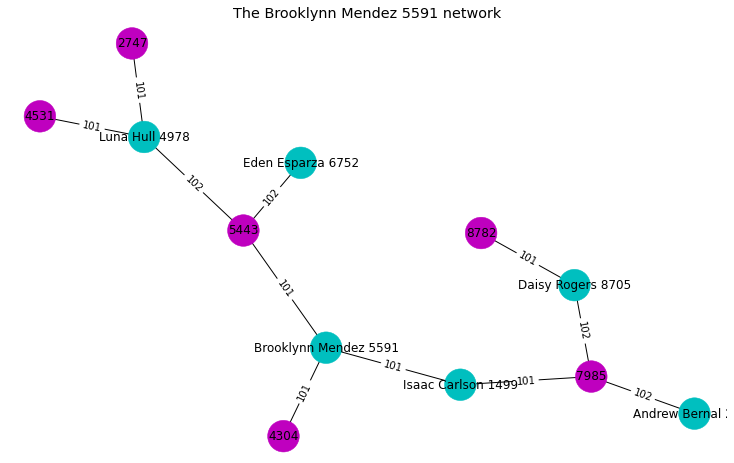

In [40]:
#specify subgraph
graph = multi[0]

colors = generate_color_map(graph,ind)

#find center of graph and use it to determine name
center = nx.center(graph)[0]
title = graph.nodes[center]['label']

#determine number of degrees and nodes
degrees = nx.degree(graph)
node_count = len(nx.nodes(graph))

#layout for display
pos = nx.spring_layout(graph)

#draw function
nx.draw(graph, pos=pos, node_color=colors, node_size=1000)

#add node labels
node_labels = nx.get_node_attributes(graph,'label')
nx.draw_networkx_labels(graph, pos=pos, labels = node_labels )

#add edge labels
edge_labels = nx.get_edge_attributes(graph, 'participation_type')
nx.draw_networkx_edge_labels(graph, pos, edge_labels)

# separate member nodes and individual nodes
i,m = separate_members_individuals(graph)

# convert node dictionaries to dataframes
i = pd.DataFrame.from_dict(i, orient='index')
m = pd.DataFrame.from_dict(m, orient='index')

# calculate summary stats of membership attributes
total_loan = sum(m['open_loan_bal'])
total_saving = sum(m['open_sv_bal'])
loan_count = sum(m['opn_ln_all_cnt'])
saving_count = sum(m['opn_sv_all_cnt'])
total_dividend = sum(m['div_ytd_amt'])
total_interest = sum(m['int_ytd_amt'])

products_per_member = (loan_count + saving_count) / len(m)

#Output
#print(f'The {title} network')

plt.title(f'The {title} network')
plt.savefig("Graph.png", format="PNG", bbox_inches='tight')
#plt.show()

# print summary stats
#print(nx.info(graph))
print(f'Member Subgraph Characteristics')
print('='*30)
print(f'Center:\t{title}')
print(f'Nodes:\t\t{node_count}')
print(f'Individuals:\t{len(i)}')
print(f'Memberships:\t{len(m)}')
print()
print(f'Subgraph Accounts Summary')
print(f'='*30)
print(f'total savings:\t\t${total_saving:,.2f}')
print(f'total loans:\t\t${total_loan:,.2f}')
print(f'PPM:\t\t\t{products_per_member:.2n}')
print(f'dividends paid:\t\t${total_dividend:,.2f}')
print(f'interest received:\t${total_interest:,.2f}')



## Prototype of visulaization with tables and export

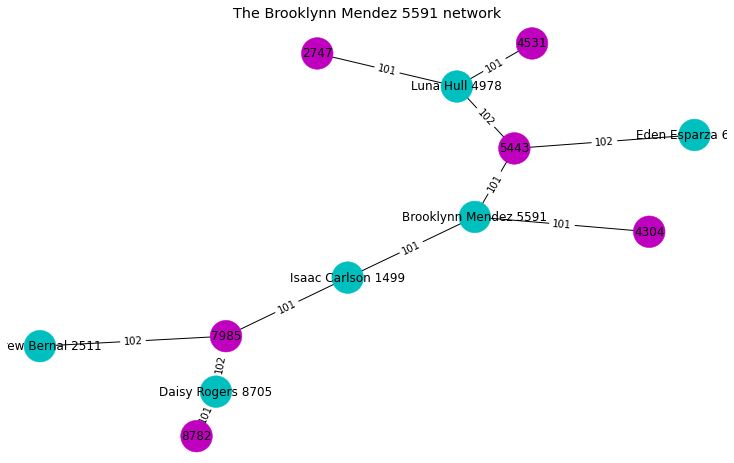

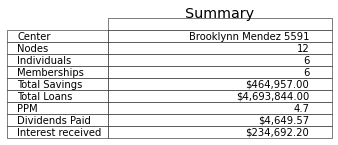

In [77]:
#specify subgraph
graph = multi[0]
colors = generate_color_map(graph,ind)

# initialize graph fig
fig1=plt.figure()

#find center of graph and use it to determine name
center = nx.center(graph)[0]
title = graph.nodes[center]['label']

#determine number of degrees and nodes
degrees = nx.degree(graph)
node_count = len(nx.nodes(graph))

#layout for display
pos = nx.spring_layout(graph)

#draw function
nx.draw(graph, pos=pos, node_color=colors, node_size=1000)

#add node labels
node_labels = nx.get_node_attributes(graph,'label')
nx.draw_networkx_labels(graph, pos=pos, labels = node_labels )

#add edge labels
edge_labels = nx.get_edge_attributes(graph, 'participation_type')
nx.draw_networkx_edge_labels(graph, pos, edge_labels)

# separate member nodes and individual nodes
i,m = separate_members_individuals(graph)

# convert node dictionaries to dataframes
i = pd.DataFrame.from_dict(i, orient='index')
m = pd.DataFrame.from_dict(m, orient='index')

# calculate summary stats of membership attributes
total_loan = sum(m['open_loan_bal'])
total_saving = sum(m['open_sv_bal'])
loan_count = sum(m['opn_ln_all_cnt'])
saving_count = sum(m['opn_sv_all_cnt'])
total_dividend = sum(m['div_ytd_amt'])
total_interest = sum(m['int_ytd_amt'])

products_per_member = (loan_count + saving_count) / len(m)

plt.title(f'The {title} network')

# save as png
# plt.savefig(f'{title} graph.png', format="PNG", bbox_inches='tight')

# make summary table formatted for display
account_dict = {'Center':title,
                'Nodes':node_count, 
                'Individuals':len(i), 
                'Memberships':len(m),
                'Total Savings':f'${total_saving:,.2f}', 
                'Total Loans':f'${total_loan:,.2f}', 
                'PPM':f'{products_per_member:.2n}', 
                'Dividends Paid':f'${total_dividend:,.2f}', 
                'Interest received':f'${total_interest:,.2f}'}

act_df = pd.DataFrame.from_dict(account_dict, orient='index')
act_df = act_df.rename(columns={0:''})

export_list = [f'=HYPERLINK("{title}.pdf")', node_count, len(i), len(m), total_saving, total_loan, products_per_member, total_dividend,
              total_interest]

# format summary table for saving
fig2 = plt.figure(figsize = (4, 2))
ax = fig2.add_subplot(111)

ax.table(cellText = act_df.values,
          rowLabels = act_df.index,
          colLabels = act_df.columns,
          loc = "center"
         )
ax.set_title("Summary")
ax.axis("off")

# save table as png
# fig2.savefig(f'{title} table.png', format = 'PNG', bbox_inches = 'tight')

# save graph and table as pdf
pp = PdfPages(f'{title}.pdf')
pp.savefig(fig1, bbox_inches='tight')
pp.savefig(fig2, bbox_inches='tight')
pp.close()


### Test visualizing all subgraphs

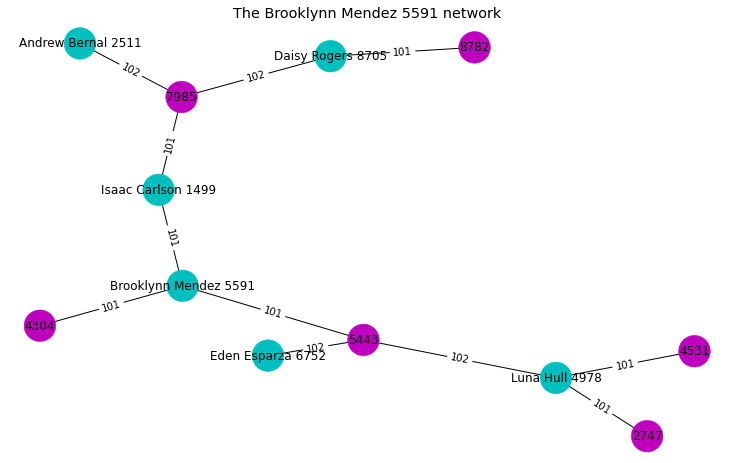

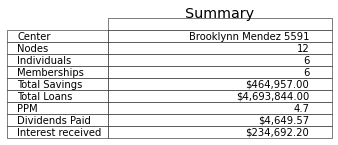

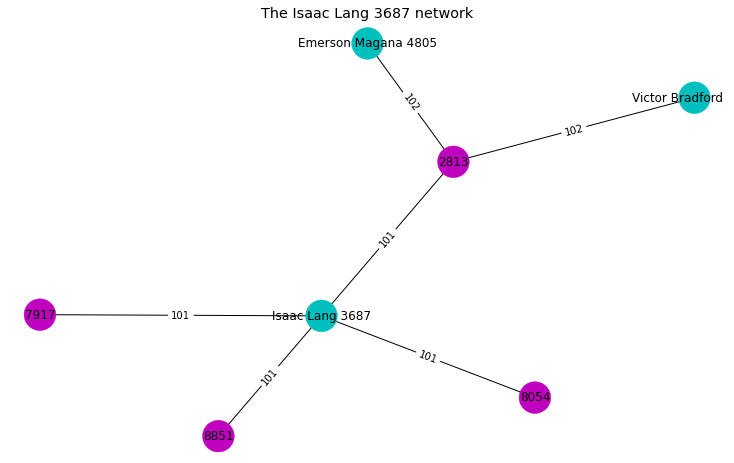

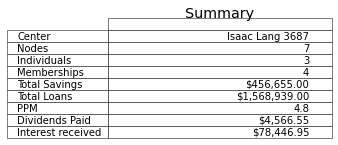

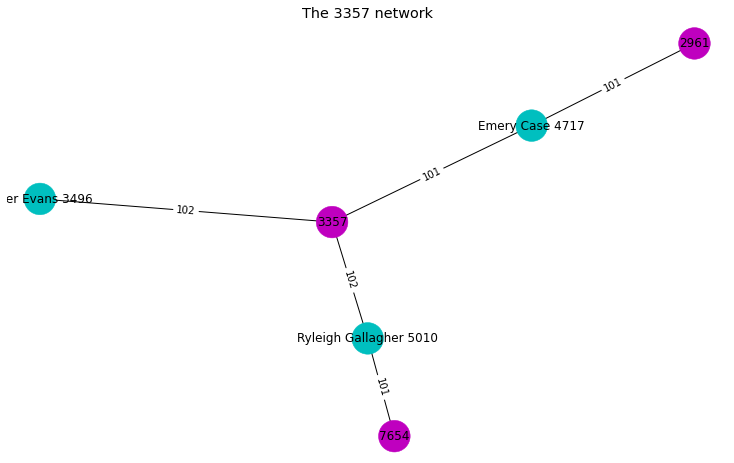

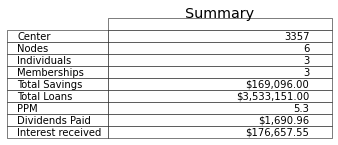

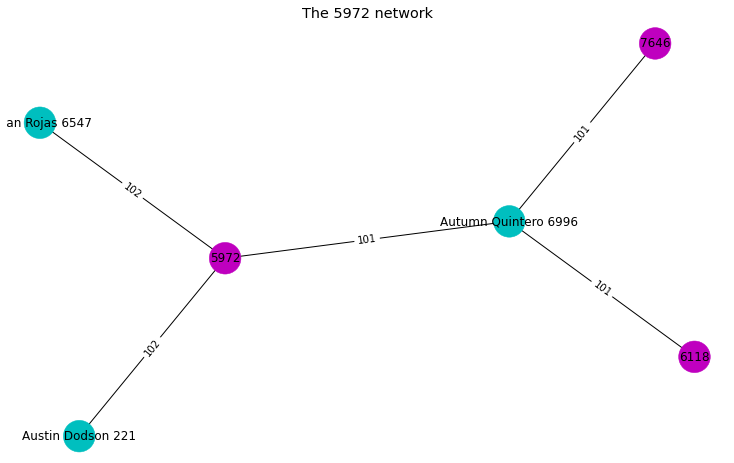

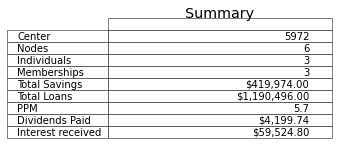

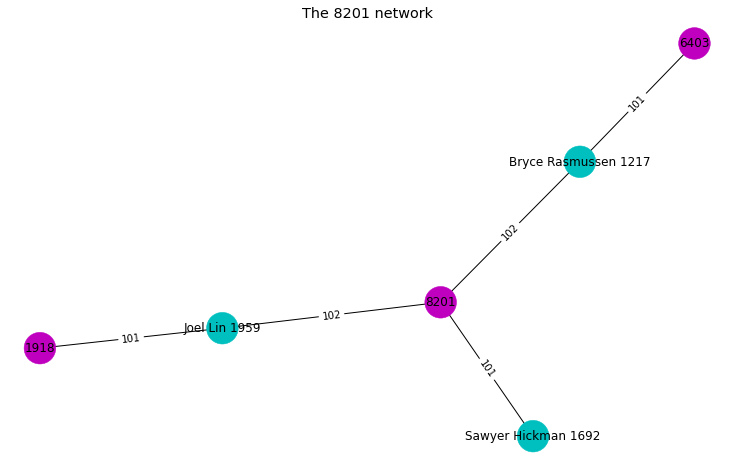

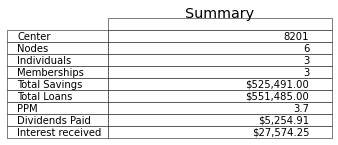

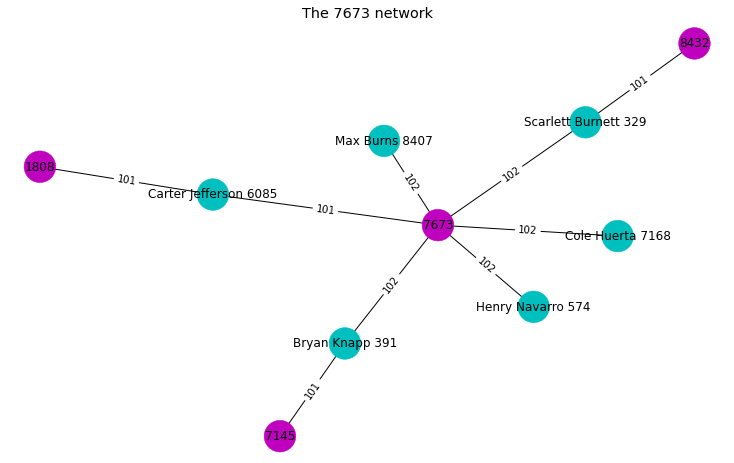

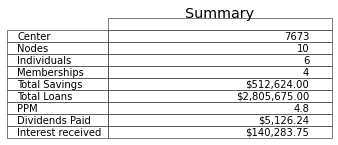

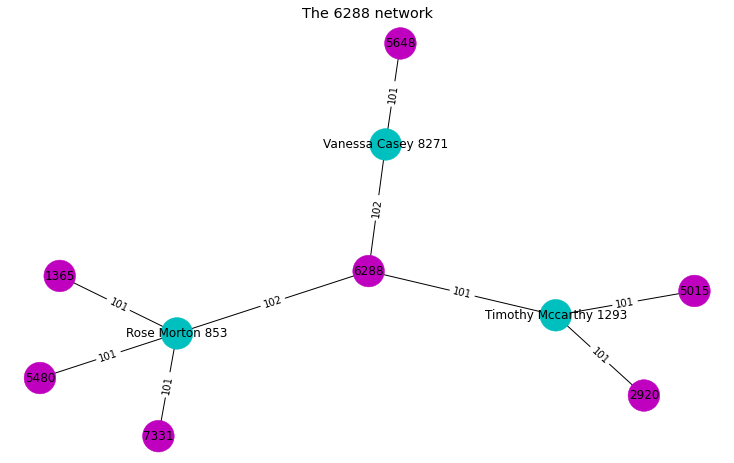

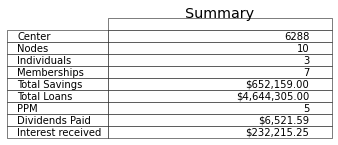

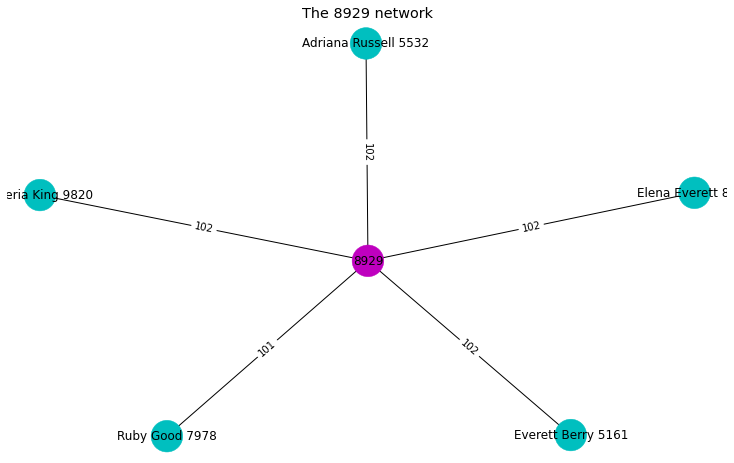

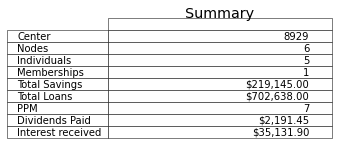

In [107]:
subnetwork_df = []
columns = ['Center', 'Nodes', 'Individuals', 'Memberships', 'Total Savings', 'Total Loans', 
           'PPM', 'Dividends Paid', 'Interest Received']
timestamp = datetime.now().date().strftime("%b %d %Y ")

for i in range(8):
    #specify subgraph
    graph = multi[i]
    colors = generate_color_map(graph,ind)

    # initialize graph fig
    fig1=plt.figure()

    #find center of graph and use it to determine name
    center = nx.center(graph)[0]
    title = graph.nodes[center]['label']

    #determine number of degrees and nodes
    degrees = nx.degree(graph)
    node_count = len(nx.nodes(graph))

    #layout for display
    pos = nx.spring_layout(graph)

    #draw function
    nx.draw(graph, pos=pos, node_color=colors, node_size=1000)

    #add node labels
    node_labels = nx.get_node_attributes(graph,'label')
    nx.draw_networkx_labels(graph, pos=pos, labels = node_labels )

    #add edge labels
    edge_labels = nx.get_edge_attributes(graph, 'participation_type')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels)

    # separate member nodes and individual nodes
    i,m = separate_members_individuals(graph)

    # convert node dictionaries to dataframes
    i = pd.DataFrame.from_dict(i, orient='index')
    m = pd.DataFrame.from_dict(m, orient='index')

    # calculate summary stats of membership attributes
    total_loan = sum(m['open_loan_bal'])
    total_saving = sum(m['open_sv_bal'])
    loan_count = sum(m['opn_ln_all_cnt'])
    saving_count = sum(m['opn_sv_all_cnt'])
    total_dividend = sum(m['div_ytd_amt'])
    total_interest = sum(m['int_ytd_amt'])

    products_per_member = (loan_count + saving_count) / len(m)

    plt.title(f'The {title} network')

    # save as png
    # plt.savefig(f'{title} graph.png', format="PNG", bbox_inches='tight')

    # make summary table formatted for display
    account_dict = {'Center':title,
                    'Nodes':node_count, 
                    'Individuals':len(i), 
                    'Memberships':len(m),
                    'Total Savings':f'${total_saving:,.2f}', 
                    'Total Loans':f'${total_loan:,.2f}', 
                    'PPM':f'{products_per_member:.2n}', 
                    'Dividends Paid':f'${total_dividend:,.2f}', 
                    'Interest received':f'${total_interest:,.2f}'}

    act_df = pd.DataFrame.from_dict(account_dict, orient='index')
    act_df = act_df.rename(columns={0:''})
    
    # Hyperlink formula included to make formula in excel
    export_list = [f'=HYPERLINK("{title}.pdf")', node_count, len(i), len(m), total_saving, total_loan, products_per_member, total_dividend,
                  total_interest]

    # format summary table for saving
    fig2 = plt.figure(figsize = (4, 2))
    ax = fig2.add_subplot(111)

    ax.table(cellText = act_df.values,
              rowLabels = act_df.index,
              colLabels = act_df.columns,
              loc = "center"
             )
    ax.set_title("Summary")
    ax.axis("off")

    # save table as png
    # fig2.savefig(f'{title} table.png', format = 'PNG', bbox_inches = 'tight')

    # save graph and table as pdf
    pp = PdfPages(f'{title}.pdf')
    pp.savefig(fig1, bbox_inches='tight')
    pp.savefig(fig2, bbox_inches='tight')
    pp.close()
    subnetwork_df.append(export_list)

# Export to an excel spreadsheet with links to pdfs
d = pd.DataFrame(subnetwork_df, columns = columns)
d.to_excel(f'Member subnetworks - {timestamp}.xlsx')

### old code 

In [ ]:

with PdfPages(r'C:\Users\Ron\Desktop\Charts.pdf') as export_pdf:
  
    plt.scatter(df1['Unemployment_Rate'], df1['Stock_Index_Price'], color='green')
    plt.title('Unemployment Rate Vs Stock Index Price', fontsize=10)
    plt.xlabel('Unemployment Rate', fontsize=8)
    plt.ylabel('Stock Index Price', fontsize=8)
    plt.grid(True)
    export_pdf.savefig()
    plt.close()
      
    plt.plot(df2['Year'], df2['Unemployment_Rate'], color='red', marker='o')
    plt.title('Unemployment Rate Vs Year', fontsize=10)
    plt.xlabel('Year', fontsize=8)
    plt.ylabel('Unemployment Rate', fontsize=8)
    plt.grid(True)
    export_pdf.savefig()
    plt.close()

In [ ]:
# set colors
member_nodes = list(edges['source'])
individual_nodes = list(edges['target'])
for n in G.nodes():
    G.nodes[n]['color'] = 'b' if n in member_nodes else 'o'
colors = [node[1]['color'] for node in G.nodes(data=True)]

In [ ]:
# filter for subgraphs with n nodes
n =6 
multi=[]
for sub in S:
    nodes = nx.nodes(sub)
    node_count = len(nodes)
    if node_count>=n:
        multi.append(sub)

print(f'{len(multi)} networks with at least {n} nodes')

In [13]:
## Code for flattening a subgraph 
#flat_list = [item for sublist in list(multi[0].edges) for item in sublist ]

#degree view
list(multi[0].degree)

#edge view
list(multi[0].edges)

#nodes
list(multi[0].nodes)

[6752, 8705, 5443, 8782, 2511, 4304, 7985, 4978, 4531, 5591, 1499, 2747]

In [15]:
# make subgraphs from all the connected components within the original dataset
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

# node count summary statisitcs of subgraphs
node_count = []
for sub in S:
    count = len(nx.nodes(sub))
    node_count.append(count)
    
print(f'min nodes {min(node_count)}')
print(f'max nodes {max(node_count)}')
print(f'average nodes {sum(node_count)/len(node_count)}')


NameError: name 'S' is not defined

In [ ]:
#specify subgraph
graph = multi[0]

colors = generate_color_map(graph,ind)

#find center of graph and use it to determine name
center = nx.center(graph)[0]
title = graph.nodes[center]['label']

#determine number of degrees and nodes
degrees = nx.degree(graph)
node_count = len(nx.nodes(graph))

# separate member nodes and individual nodes
i,m = separate_members_individuals(graph)

# convert node dictionaries to dataframes
i = pd.DataFrame.from_dict(i, orient='index')
m = pd.DataFrame.from_dict(m, orient='index')

# calculate summary stats of membership attributes
total_loan = sum(m['open_loan_bal'])
total_saving = sum(m['open_sv_bal'])
loan_count = sum(m['opn_ln_all_cnt'])
saving_count = sum(m['opn_sv_all_cnt'])
total_dividend = sum(m['div_ytd_amt'])
total_interest = sum(m['int_ytd_amt'])

products_per_member = (loan_count + saving_count) / len(m)

fig1=plt.figure()
ax1=fig1.add_subplot(111)
ax1.set_title(title)

#layout for display
pos = nx.spring_layout(graph)

#draw function
nx.draw(graph, pos=pos, node_color=colors, node_size=1000)

#add node labels
node_labels = nx.get_node_attributes(graph,'label')
nx.draw_networkx_labels(graph, pos=pos, labels = node_labels )

#add edge labels
edge_labels = nx.get_edge_attributes(graph, 'participation_type')
nx.draw_networkx_edge_labels(graph, pos, edge_labels)

fig2=plt.figure()
ax2=fig2.add_subplot(221)

ax2.set_title(title + str(' individuals'))
ax2.axis('off')
ax2.table(cellText=m.values, colLabels=m.columns, bbox=[0,0,1,1])

ax3=fig2.add_subplot(222)
ax3.set_title(title + str(' member numbers'))
ax3.table(cellText=i.values, colLabels=i.columns, bbox=[0,0,1,1])
ax3.axis('off')

pp = PdfPages("foo.pdf")
pp.savefig(fig1, bbox_inches='tight')
pp.savefig(fig2, bbox_inches='tight')
pp.close()


In [ ]:
for i in range(8):
    
    graph = multi[i]
    
    #individual_nodes = []

    #for name in list(graph.nodes):
    #    if " " in str(name):
    #        individual_nodes.append(name)
            
    colors = generate_color_map(graph,ind)

    center = nx.center(graph)[0]
    title = graph.nodes[center]['label']
    degrees = nx.degree(graph)
    node_count = len(nx.nodes(graph))
    
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos=pos, node_color=colors,   node_size=1000)
    node_labels = nx.get_node_attributes(graph,'label')

    nx.draw_networkx_labels(graph, pos=pos, labels = node_labels )
    edge_labels = nx.get_edge_attributes(graph, 'participation_type')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels)
    
    print(f'The {title} network')
    print(str(node_count)+" nodes")
    plt.show()

    
    
fig, ax =plt.subplots(figsize=(12,4))

ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')

#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("foo.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [ ]:
fig1=plt.figure()
    ax1=fig1.add_subplot(111)
    ax1.set_title(title)
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos=pos, node_color=colors,   node_size=1000, ax=ax1)
    nx.draw_networkx_labels(graph, pos=pos )
    #plt.show()
    
    fig2=plt.figure()
    ax2=fig2.add_subplot(221)

    ax2.set_title(title + str(' individuals'))
    ax2.axis('off')
    ax2.table(cellText=df1.values, colLabels=df1.columns, bbox=[0,0,1,1])
    #ax.table(cellText=df2.values, colLabels=df2.columns, bbox=[0,0,1,1])


    ax3=fig2.add_subplot(222)
    ax3.set_title(title + str(' member numbers'))
    ax3.table(cellText=df2.values, colLabels=df2.columns, bbox=[0,0,1,1])
    ax3.axis('off')
    #plt.show();
    
    pp = PdfPages(file_name+'.pdf')
    pp.savefig(fig1)
    #pp.savefig(fig2)
        
    pp.close()
    plt.clf()

In [ ]:

#function to separate membership from individuals for display
#names,member_nbrs = get_network_members(degrees)

#function to join attributes back on subgraph node
#at = get_member_nbr_attributes(attributes,member_nbrs )

#print(pd.DataFrame.from_dict(nx.degree(graph)))
#print(names)
#print(at)

In [ ]:
def get_member_nbr_attributes(attribute_dataframe, node_dataframe):
    attributes = pd.merge(node_dataframe, attribute_dataframe, on = 'member_nbr')
    return(attributes)
    

In [ ]:
#not necessary with new query
def get_network_members(degree_dictionary):
    td = pd.DataFrame.from_dict(degree_dictionary)
    names = td.loc[td[0].str.contains(r"([" "] | [a-z])", na=False)]
    names = names.rename(columns={0:'name/individual ID', 1:'degrees'})
    member_nbrs = td.loc[~td.index.isin(names.index)]
    member_nbrs = member_nbrs.rename(columns={0:'member_nbr', 1:'degrees'})

    return(names, member_nbrs)


In [ ]:
###############
# Retain for proof of concept code

def generate_color_map(graph_object, individual_df):
    individual_nodes = list(ind['individual_id'])
    
    for name in list(graph_object.nodes):
        if " " in str(name):
            individual_nodes.append(name)
    
    for n in graph_object.nodes:
        graph_object.nodes[n]['color'] = 'c' if n in individual_nodes else 'm'
    
    colors = [node[1]['color'] for node in graph_object.nodes(data = True)]
    return(colors)

In [ ]:
#####################################################
#OLD QUERIES FOR PROOF OF CONCEPT
####################################################

# if using live datamart
t_sql_query = '''
select  a.member_nbr [source], concat((c.first_name + space(1) + c.last_name + space(1)),  a.individual_id) [target] , a.participation_type
from membershipparticipant_today a

--left join agr_membertotal_today b on a.member_nbr = b.member_nbr
left join individual_today c on a.individual_id = c.individual_id
'''

# if using sqlite demo database
sqlite_query = '''
select  
    a.member_nbr [source], 
    c.first_name || ' ' || c.last_name || ' '||  a.individual_id [target] , 
    a.participation_type, b.open_loan_bal

from membershipparticipant_today a

left join agr_membertotal_today b on a.member_nbr = b.member_nbr
left join individual_today c on a.individual_id = c.individual_id
'''

attribute_query = '''
select member_nbr, open_loan_bal
from agr_membertotal_today

'''

In [ ]:
##THIS WORKS BUT IS IT REDUNDANT
memlist = list(mem['member_nbr'])
indlist = list(ind['individual_id'])
node_list = set(memlist + indlist)

def make_edge_list(edge_df):
    list1 = list(edge_df['source'])
    list2 = list(edge_df['target'])
    edge_list = list(zip(list1, list2))
    return(edge_list)

edge_list = make_edge_list(edges)

mem_dict = mem.set_index('member_nbr')
mem_dict = mem_dict.to_dict('index')

ind_dict = ind.set_index('individual_id')
ind_dict = ind_dict.to_dict('index')

g=nx.Graph()
g.add_nodes_from(indlist)
nx.set_node_attributes(g, ind_dict)

g.add_nodes_from(memlist)
nx.set_node_attributes(g, mem_dict)

g.add_edges_from(edge_list)

list(g.nodes.data())

In [ ]:
#THIS WORKS TOO USING ONLY ONE PASS WITH ADDING EDGES, SETTING ATTRIBUTES

ind = pd.read_sql(node_individual_query, conn)
mem = pd.read_sql(member_individual_query, conn)
edges= pd.read_sql(edge_query, conn)

memlist = list(mem['member_nbr'])
indlist = list(ind['individual_id'])
node_list = set(memlist + indlist)

def make_edge_list(edge_df):
    list1 = list(edge_df['source'])
    list2 = list(edge_df['target'])
    edge_list = list(zip(list1, list2))
    return(edge_list)

edge_list = make_edge_list(edges)

mem_dict = mem.set_index('member_nbr')
mem_dict = mem_dict.to_dict('index')
ind_dict = ind.set_index('individual_id')
ind_dict = ind_dict.to_dict('index')

mem_dict.update(ind_dict)

g=nx.Graph()
g.add_edges_from(edge_list)
nx.set_node_attributes(g, mem_dict)

list(g.nodes.data())